# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

We first load the model files and set the top layers' name.

In [2]:
if not os.path.isfile('../models/COCO/GoogleNetCOCO.caffemodel'):
    url = 'http://www.cs.bu.edu/groups/ivc/data/ExcitationBP/COCO/GoogleNetCOCO.caffemodel'
    urllib.urlretrieve(url, '../models/COCO/GoogleNetCOCO.caffemodel')
caffe.set_mode_gpu()
net = caffe.Net('../models/bvlc_googlenet/deploy_bp.prototxt',
                '../models/bvlc_googlenet/bvlc_googlenet_bp.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()
imgScale = 224
topBlobName = 'loss3/classifier'
topLayerName = 'loss3/classifier_bp'
fwdLayerName = 'probe'
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = 'pool5/7x7_s1'

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

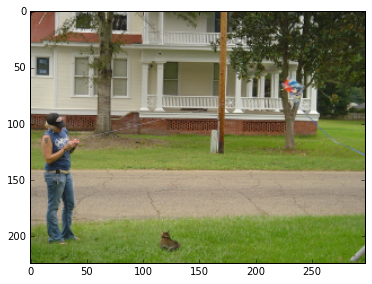

In [3]:
imgName = 'COCO_val2014_000000139781.jpg'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [4]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = topLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

KeyError: 'loss3/classifier_bp'

/usr/local/lib/python2.7/dist-packages/skimage/_shared/utils.py:174: skimage_deprecation: Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be removed in a future release.
  "Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be "


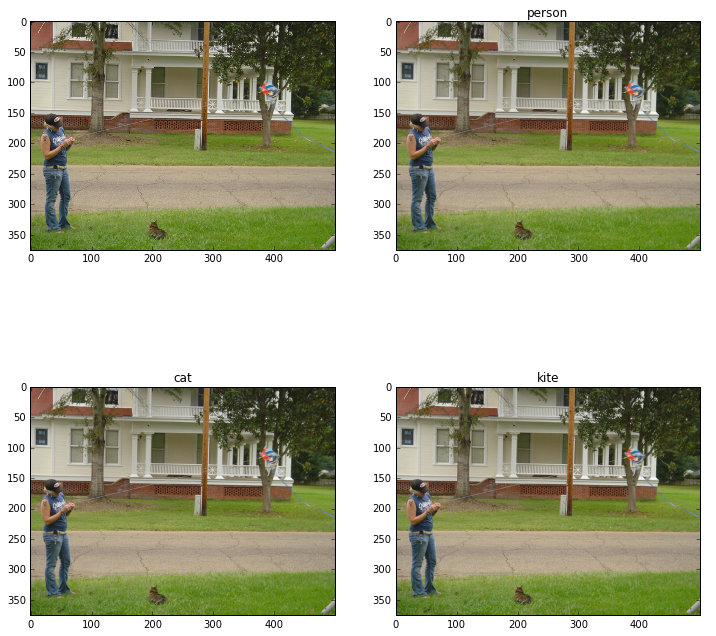

In [5]:
# switch to the excitation backprop mode
caffe.set_mode_eb_gpu() 
# specify the tags
tagName = ['person', 'cat', 'kite']
#specify the output layer name
outputLayerName = 'pool3/3x3_s2'#'inception_5b/output'
outputBlobName = 'pool3/3x3_s2'#'inception_5b/output'

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
    net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()

    # invert the top layer weights
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()

    # invert back
    net.params[topLayerName][0].data[...] *= -1 
    out = net.backward(start = topLayerName, end = secondTopLayerName)

    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)
    attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)


Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

We also compare with the deconvolution method.

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


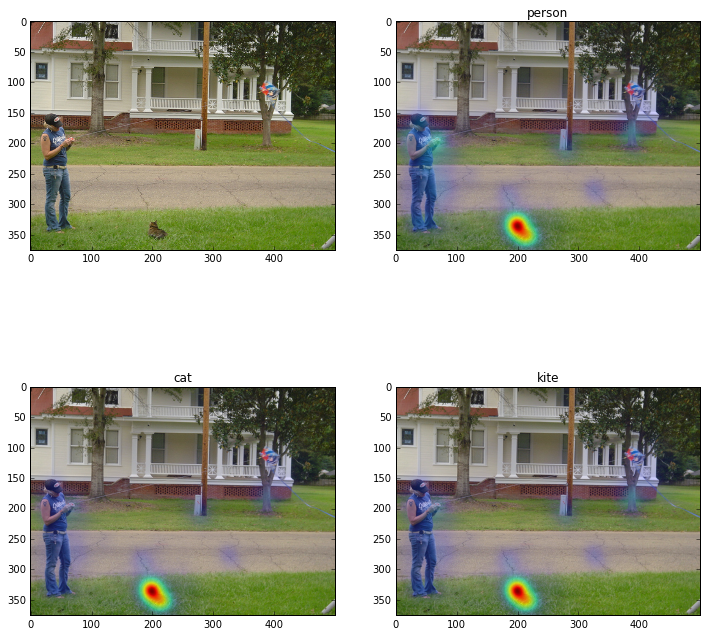

In [6]:
# switch to the deconvolution mode
caffe.set_mode_dc_gpu() 
tagName = ['person', 'cat', 'kite']
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID])
    out = net.backward(start = topLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)

Compare with the gradient method

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


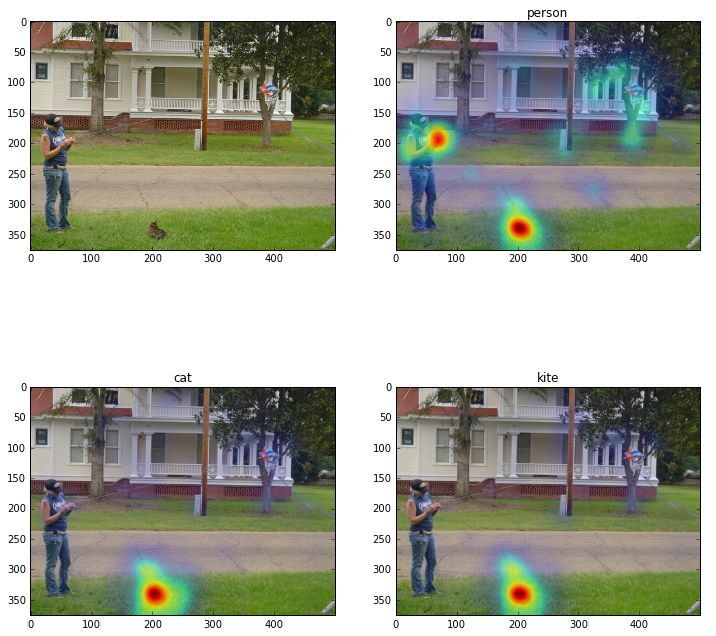

In [7]:
# Switch to the normal error backpropagation mode
caffe.set_mode_gpu() 
tagName = ['person', 'cat', 'kite']
attMaps = []
for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID])
    out = net.backward(start = topLayerName)
    attMap = np.abs(net.blobs['data'].diff[0]).max(0)
    attMaps.append(attMap)
    
util.showAttMap(img, attMaps, tagName, overlap = True, blur = True)